In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from sklearn.model_selection import KFold

2024-07-29 17:53:25.353820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 17:53:25.353946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 17:53:25.483936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_dir = "C:/Users/Bhushan/Desktop/Plant disease detection/Plant_leave_diseases_dataset_with_augmentation"

# Parameters for the data generator
image_size = (224, 224)
batch_size = 32

# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Create the dataset from the directory
dataset = datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
# Print the class indices to understand the mapping
print(dataset.class_indices)

Found 61486 images belonging to 39 classes.
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Background_without_leaves': 4, 'Blueberry___healthy': 5, 'Cherry___Powdery_mildew': 6, 'Cherry___healthy': 7, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8, 'Corn___Common_rust': 9, 'Corn___Northern_Leaf_Blight': 10, 'Corn___healthy': 11, 'Grape___Black_rot': 12, 'Grape___Esca_(Black_Measles)': 13, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14, 'Grape___healthy': 15, 'Orange___Haunglongbing_(Citrus_greening)': 16, 'Peach___Bacterial_spot': 17, 'Peach___healthy': 18, 'Pepper,_bell___Bacterial_spot': 19, 'Pepper,_bell___healthy': 20, 'Potato___Early_blight': 21, 'Potato___Late_blight': 22, 'Potato___healthy': 23, 'Raspberry___healthy': 24, 'Soybean___healthy': 25, 'Squash___Powdery_mildew': 26, 'Strawberry___Leaf_scorch': 27, 'Strawberry___healthy': 28, 'Tomato___Bacterial_spot': 29, 'Tomato___Early_blight': 30, 'Tomato___Late_blight': 3

In [3]:
disease_types = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 
    'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 
    'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 
    'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 
    'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 
    'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 
    'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 
    'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 
    'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]
train_dir = os.path.join(dataset_dir)

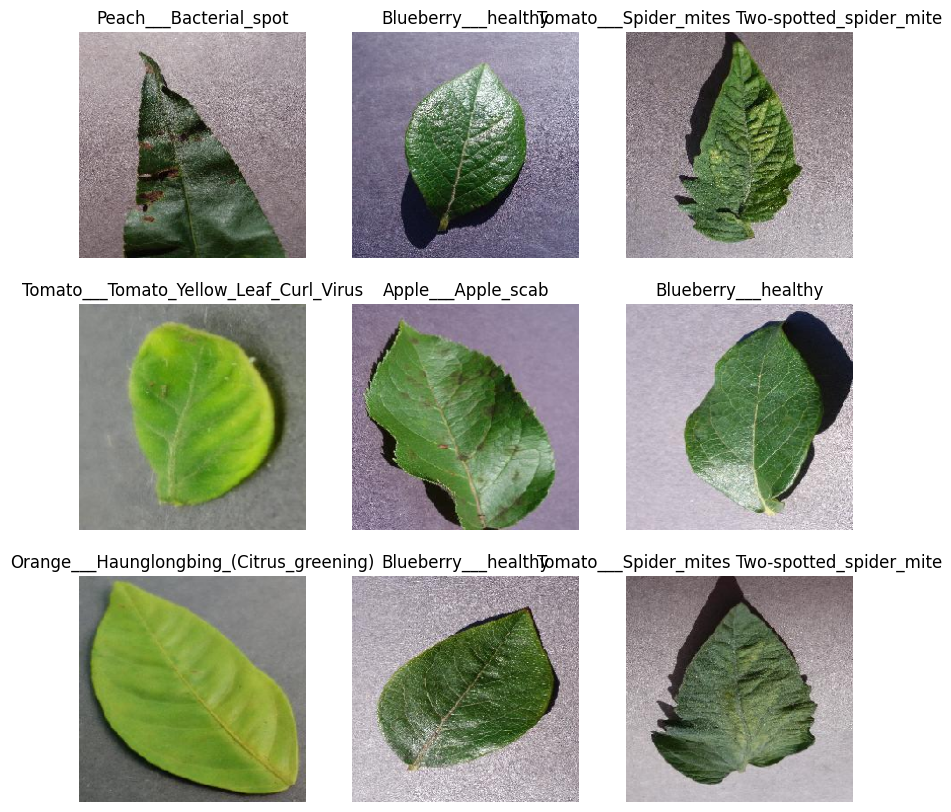

In [4]:
# Get a batch of images and labels
image_batch, label_batch = next(dataset)

# Create an inverse mapping from class_indices
inverse_class_indices = {v: k for k, v in dataset.class_indices.items()}

# Display the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    # Use the inverse mapping to get the class name
    class_index = label_batch[i].argmax()
    class_name = inverse_class_indices[class_index]
    plt.title(class_name)
    plt.axis("off")
plt.show()

In [5]:
class_names = list(dataset.class_indices.keys())

# Count the number of images in each class directory
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Print the class distribution from directory
print("Class distribution from directory:")
for class_name, count in class_counts.items():
    print(f"Class {class_name}: {count} images")

# Initialize class counts
class_counts = {class_name: 0 for class_name in class_names}


Class distribution from directory:
Class Apple___Apple_scab: 1000 images
Class Apple___Black_rot: 1000 images
Class Apple___Cedar_apple_rust: 1000 images
Class Apple___healthy: 1645 images
Class Background_without_leaves: 1143 images
Class Blueberry___healthy: 1502 images
Class Cherry___Powdery_mildew: 1052 images
Class Cherry___healthy: 1000 images
Class Corn___Cercospora_leaf_spot Gray_leaf_spot: 1000 images
Class Corn___Common_rust: 1192 images
Class Corn___Northern_Leaf_Blight: 1000 images
Class Corn___healthy: 1162 images
Class Grape___Black_rot: 1180 images
Class Grape___Esca_(Black_Measles): 1383 images
Class Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Class Grape___healthy: 1000 images
Class Orange___Haunglongbing_(Citrus_greening): 5507 images
Class Peach___Bacterial_spot: 2297 images
Class Peach___healthy: 1000 images
Class Pepper,_bell___Bacterial_spot: 1000 images
Class Pepper,_bell___healthy: 1478 images
Class Potato___Early_blight: 1000 images
Class Potato___L

In [6]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
61481,Tomato___healthy/image (830).JPG,38,Tomato___healthy
61482,Tomato___healthy/image (536).JPG,38,Tomato___healthy
61483,Tomato___healthy/image (624).JPG,38,Tomato___healthy
61484,Tomato___healthy/image (609).JPG,38,Tomato___healthy
61485,Tomato___healthy/image (63).JPG,38,Tomato___healthy


In [7]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Orange___Haunglongbing_(Citrus_greening)/image...,16,Orange___Haunglongbing_(Citrus_greening)
1,Peach___Bacterial_spot/image (1628).JPG,17,Peach___Bacterial_spot
2,"Pepper,_bell___healthy/image (652).JPG",20,"Pepper,_bell___healthy"
3,Orange___Haunglongbing_(Citrus_greening)/image...,16,Orange___Haunglongbing_(Citrus_greening)
4,Tomato___Septoria_leaf_spot/image (1350).JPG,33,Tomato___Septoria_leaf_spot


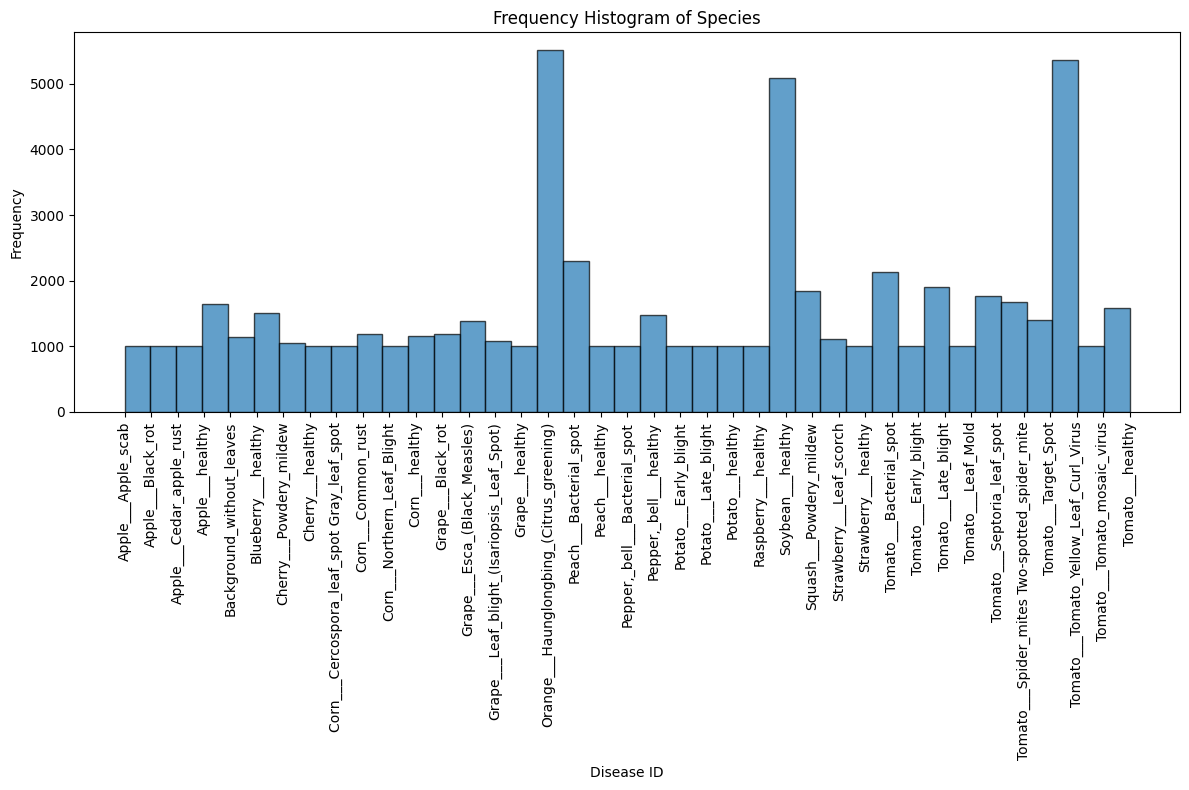

In [8]:
plt.figure(figsize=(12, 8))  # Set the figure size before plotting
plt.hist(train['DiseaseID'], bins=len(disease_types), edgecolor='black', alpha=0.7)
plt.title('Frequency Histogram of Species')
plt.xlabel('Disease ID')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(disease_types)), labels=disease_types, rotation=90)  # Set the x-ticks to show disease names
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlapping
plt.show()


In [9]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(dataset_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [10]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

61486it [08:10, 125.42it/s]


Train Shape: (61486, 64, 64, 3)


In [11]:
X_train[0]

array([[[195., 208., 222.],
        [193., 206., 220.],
        [190., 203., 217.],
        ...,
        [170., 183., 199.],
        [163., 176., 192.],
        [160., 173., 189.]],

       [[201., 214., 228.],
        [204., 217., 231.],
        [190., 203., 217.],
        ...,
        [176., 189., 205.],
        [157., 170., 186.],
        [160., 173., 189.]],

       [[196., 209., 223.],
        [199., 212., 226.],
        [198., 211., 225.],
        ...,
        [166., 179., 195.],
        [169., 182., 198.],
        [164., 176., 192.]],

       ...,

       [[134., 147., 169.],
        [139., 152., 174.],
        [142., 155., 177.],
        ...,
        [131., 145., 164.],
        [141., 155., 174.],
        [135., 149., 168.]],

       [[149., 162., 184.],
        [140., 153., 175.],
        [148., 161., 183.],
        ...,
        [144., 158., 177.],
        [138., 152., 171.],
        [134., 148., 167.]],

       [[128., 141., 163.],
        [151., 164., 186.],
        [136., 1

In [12]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=len(disease_types))

In [13]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [14]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

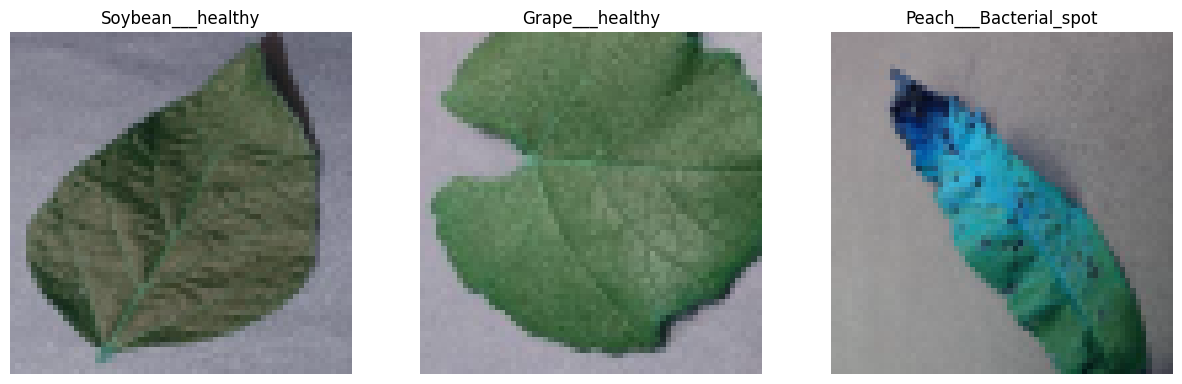

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [16]:
EPOCHS = 5
SIZE=20
N_ch=3

In [17]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)
    input = Input(shape=(64, 64, 3))  # Adjust SIZE and N_ch accordingly
    x = Conv2D(3, (3, 3), padding='same')(input)  # Adjust kernel size and padding if necessary
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(len(disease_types), activation='softmax', name='root')(x)  # Adjust number of classes

    model = Model(input, output)
    
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [18]:
# Instantiate and compile the model
model = build_densenet()

# Define callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_learning_rate=1e-3)
checkpoint = ModelCheckpoint('model.keras', verbose=1, save_best_only=True)

# Define ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=360,  # Degree range for random rotations
    width_shift_range=0.2,  # Range for random horizontal shifts
    height_shift_range=0.2,  # Range for random vertical shifts
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    vertical_flip=True  # Randomly flip inputs vertically
)

# Fit the data generator to your training data
datagen.fit(X_train)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ root (Dense)                    │ (None, 39)             │        10,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,315,131 (27.91 MB)

 Trainable params: 7,228,923 (27.58 MB)

 Non-trainable params: 86,208 (336.75 KB)

In [19]:
# Train the model
history = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_val, Y_val),
                    callbacks=[annealer, checkpoint])

# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f'Validation Accuracy: {val_acc:.2f}')
print(f'Validation Loss: {val_loss:.2f}')

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1722276342.004369     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722276342.190147     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


464/769 ━━━━━━━━━━━━━━━━━━━━ 1:31 299ms/step - accuracy: 0.1975 - loss: 3.6884

W0000 00:00:1722276480.484672     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.2892 - loss: 3.1551

W0000 00:00:1722276530.424792     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.52054, saving model to model.keras
769/769 ━━━━━━━━━━━━━━━━━━━━ 372s 269ms/step - accuracy: 0.2895 - loss: 3.1536 - val_accuracy: 0.8388 - val_loss: 0.5205 - learning_rate: 0.0020
Epoch 2/5
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8115 - loss: 0.6427
Epoch 2: val_loss improved from 0.52054 to 0.22458, saving model to model.keras
769/769 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - accuracy: 0.8115 - loss: 0.6426 - val_accuracy: 0.9280 - val_loss: 0.2246 - learning_rate: 0.0020
Epoch 3/5
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9031 - loss: 0.3264
Epoch 3: val_loss did not improve from 0.22458
769/769 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.9031 - loss: 0.3264 - val_accuracy: 0.9287 - val_loss: 0.2520 - learning_rate: 0.0020
Epoch 4/5
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9300 - loss: 0.2272
Epoch 4: val_loss did not improve from 0.22458
769/769 ━━━━━━━━━━━━━━━━━━━━ 80s 103ms/step - accuracy: 0.

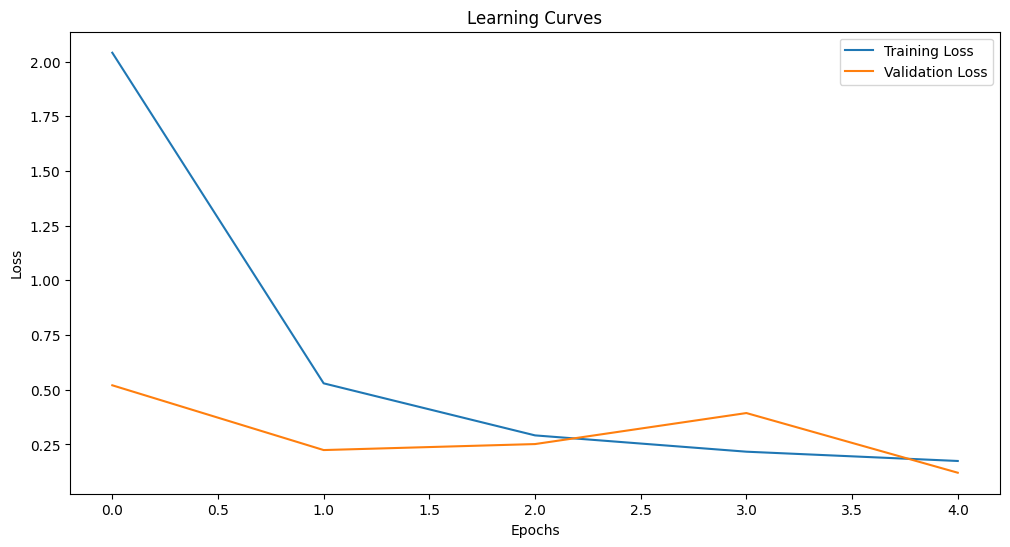

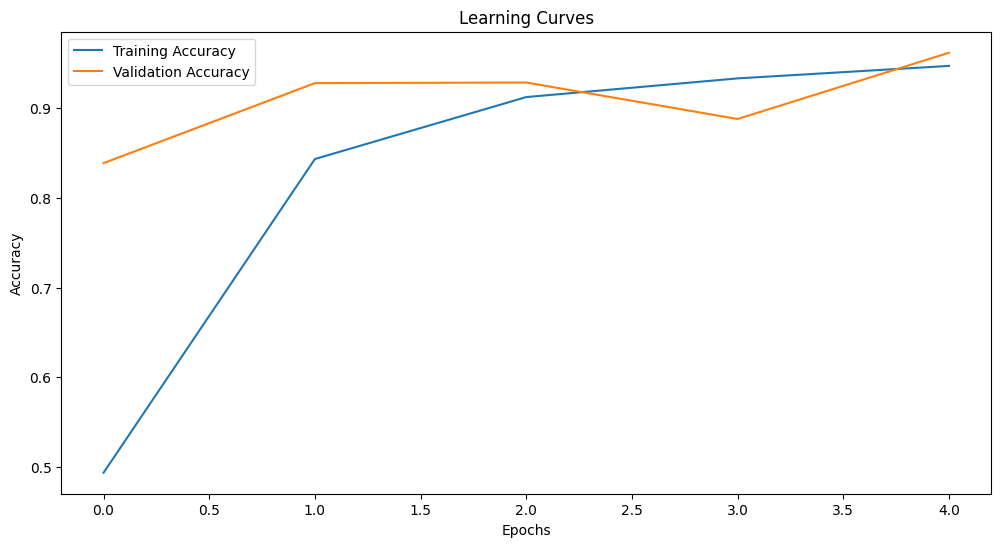

In [22]:
# Plot training and validation accuracy and loss for each model
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curves')
plt.show()


In [23]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(Y_val, axis=1)
report = classification_report(y_true, y_pred, target_names=disease_types)
print(report)

 10/385 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step  

W0000 00:00:1722276896.021982     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


385/385 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.94      0.94      0.94       214
                            Apple___Black_rot       0.97      0.97      0.97       197
                     Apple___Cedar_apple_rust       0.98      0.99      0.98       196
                              Apple___healthy       0.97      0.96      0.97       347
                    Background_without_leaves       1.00      0.96      0.98       227
                          Blueberry___healthy       0.98      1.00      0.99       309
                      Cherry___Powdery_mildew       0.99      0.96      0.98       204
                             Cherry___healthy       0.96      0.99      0.98       199
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.92      0.93       181
                           Corn___Common_rust       0.99      1.00      0.99       254

In [25]:
test_image_path = 'c:/Users/Bhushan/Desktop/Plant disease detection/Plant_leave_diseases_dataset_with_augmentation/Peach___Bacterial_spot/image (174).JPG'
test_image = cv2.imread(test_image_path)
test_image_resized = cv2.resize(test_image, (IMAGE_SIZE, IMAGE_SIZE))
test_image_resized = np.expand_dims(test_image_resized, axis=0)  # Add batch dimension
test_image_resized = test_image_resized / 255.0  # Normalize

# Predict class probabilities
predictions = model.predict(test_image_resized)
predicted_class = np.argmax(predictions)
predicted_class_name = disease_types[predicted_class]
print(predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Peach___Bacterial_spot


In [30]:
test_image_path = 'c:/Users/Bhushan/Desktop/Plant disease detection/Plant_leave_diseases_dataset_with_augmentation/Tomato___Early_blight/image (6).JPG'
test_image = cv2.imread(test_image_path)
test_image_resized = cv2.resize(test_image, (IMAGE_SIZE, IMAGE_SIZE))
test_image_resized = np.expand_dims(test_image_resized, axis=0)  # Add batch dimension
test_image_resized = test_image_resized / 255.0  # Normalize

# Predict class probabilities
predictions = model.predict(test_image_resized)
predicted_class = np.argmax(predictions)
predicted_class_name = disease_types[predicted_class]
print(predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tomato___Early_blight
